# Problem statement

Facial recognition (FR) is a biometric technology that matches the image of face against a database of images of faces, retrieving the identify. This is usually achieved by training a deep neural network to map the images to vectors that can be compared using a distance metric. This technology has rapidly advanced in recent years, with a wide range of daily uses, from improving security measures to facilitating personalized advertising.


The ability to recognise the faces of celebrity in an image can have various applications, specifically in the entertainment industry. For example, AmazonPrime used it to recognise celebrity faces in streaming shows, when the user pauses an episode. Thoughout this project, we intent to replicate this technology. Specifically, we intend to answer this question: is it possible to utilize transfer learning/in order to develop our own model in order to develop a facial recognition model capable of accurately categorizing celebrity faces sourced from the CelebA dataset?


# Explore and Visualize Data

In [ ]:
# import necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# map drive
from google.colab import drive
drive.mount('/content/drive')

# data
celeb_att = pd.read_csv('/content/drive/MyDrive/AC209B_project/Data/list_attr_celeba.csv')

Mounted at /content/drive


We will analyze a subset of attributes from the CelebA dataset. These include physical characteristics like bald, chubby, big nose, and so on. Our goal in doing this is to explore the distribution of different attributes across the dataset.

In [ ]:
# subset of attributes to explore
cols = ['Bald', 'Big_Nose', 'Black_Hair', 'Blurry', 'Chubby', 'Eyeglasses', 'Gray_Hair', 'Heavy_Makeup', 'Male', 'No_Beard',  'Pale_Skin', 'Smiling', 'Wavy_Hair', 'Wearing_Hat', 'Young']

celeb_att_subset = celeb_att[cols]
celeb_att_subset = celeb_att_subset.replace({-1: "No", 1: "Yes"})

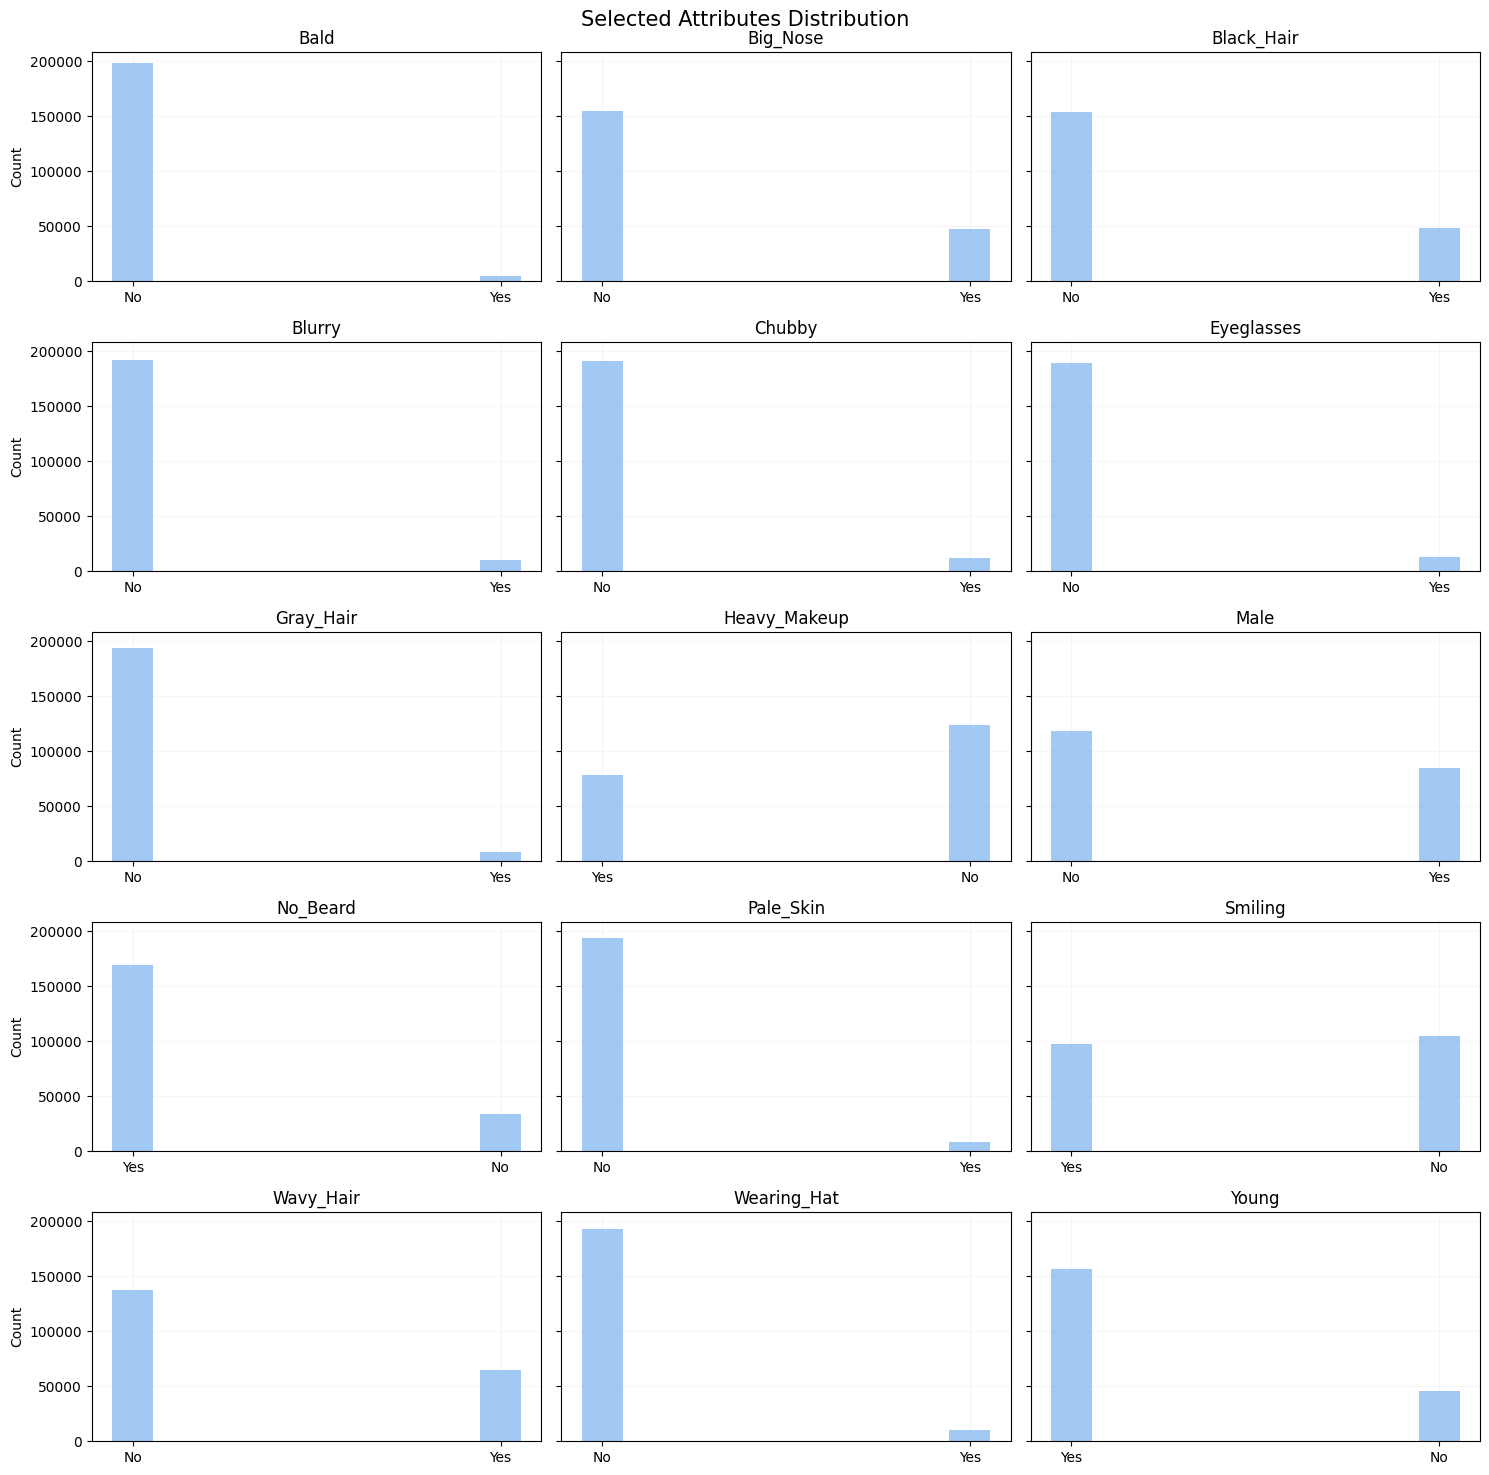

In [ ]:
# plot of selected attributes distribution
ncol = 3
nrow = 5
fig, axs = plt.subplots(nrows=5, ncols=ncol, figsize=(15,15), sharey=True)
axs = axs.ravel()

for i, ax, att in zip(range(nrow*ncol), axs, celeb_att_subset.columns):
  ax.hist(celeb_att_subset[att], color="#a1c9f4", rwidth=5)
  ax.set_xticks((0.05, 0.95))
  if i % ncol == 0:
    ax.set_ylabel("Count")
  ax.grid(alpha=0.1)
  ax.set_title(att)

plt.suptitle("Selected Attributes Distribution", fontsize=15)
plt.tight_layout()

We see that the dataset is not balanced on all the attributes. This potential domain shift would only be an issue if we were planning to use the model with a subset of celebrities that had a different distribution of the target attribute, so we will need to monitor the performance by at least some of these selected characteristics in order to prevent unfair biases. Further, it is more common to find celebrities with pale skin, young, skinny, without big noses, bears, hats or eyeglasses, to name a few.

A considerable amount of celebrities are wearing heavy makeup, something that could negatively impact the model's accuracy (but we will only be able to check this after training).

Slightly over 58% of the observations belong to female celebrities, while the remaining 42% are from male celebrities. Although there is a slight class imbalance here, the proportions are relatively close to those of the general population and the difference between the two ratios is not too large, so we believe this will not be a problem.


Finally the majority of the images are not blurry.

We will now analyze the distribution of a few attributes by gender.

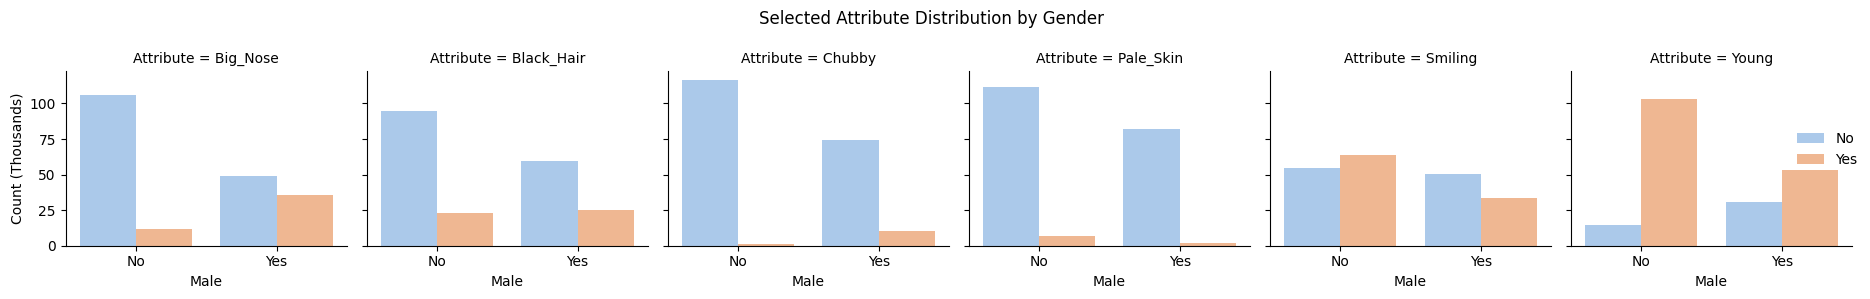

In [ ]:
# create dataframe to use with seaborn facet grid
attributes = ["Big_Nose", "Black_Hair", "Chubby", "Pale_Skin", "Smiling", "Young"]

sns_df = pd.DataFrame(columns=["Present", "Male", "Count", "Attribute"])

for att in attributes:
  data = celeb_att_subset.groupby([att, "Male"]).count()[["Bald"]].reset_index()
  data["Attribute"] = att
  data.rename(columns={"Bald": "Count", att: "Present"}, inplace=True)
  sns_df = pd.concat([sns_df, data])

# plot of selected attributes by gender
sns_df["Count"] = sns_df["Count"] / 1000
g = sns.FacetGrid(data=sns_df, col="Attribute")
g.map_dataframe(sns.barplot, x="Male", y="Count", hue="Present", palette="pastel")
g.add_legend()
g.axes[0,0].set_ylabel("Count (Thousands)")
plt.suptitle("Selected Attribute Distribution by Gender")
plt.tight_layout()
plt.show()

We can see that, for some attributes, the distribution varies significantly by gender. For example, while males have a roughly similar number of observations with and without a big nose, only a very small ratio of females has a big nose. Additionally, we can see that while there are very few chubby celebrities for either gender, the ratio between chubby and non-chubby observations is notably smaller for females. Moreover, we noticed that the ratio between the number of young and old male celebrities is less than 2, while it is almost 7 for women - indicating another yet large disparity in distribution by gender. These results might end up affecting the results of our model as some attributes will be underrepresented - an issue that might cause a class imbalance.

# Baseline Model

We use a Siamese network with shared parameters $\theta$ a self-designed CNN based architecture. The model is trained to minimize the distance of positive images pairs, i.e, pairs of different images of the same celebrity, and maximize the distance between negative pairs, i.e., images of different celebrities.


![Figure](https://drive.google.com/uc?id=14-I-hXZjE0V_PtkCh756reZJl-rodoXk)


The model was trained for 20 epochs with a batch size of 128 triplets, using the triplet loss function with a margin $m = 1$: $$\mathcal{L}(\theta) = \text{max} \left(||f_\theta(x_\text{anchor}) - f_\theta(x_\text{postive}) || - ||f_\theta(x_\text{anchor}) - f_\theta(x_\text{negative}) || + m, 0 \right)$$


[Link to our Baseline Model](https://drive.google.com/drive/folders/1iZLP0rq7WXv8T-awBTuD_INGcdrpxz6w?usp=sharing)

# Interpret the results

The model is able to minimize the loss function and map positive pairs to embeddings with reasonably high cosine similarity, and negative pairs to embeddings with reasonably low cosine similarity. But it still unable to retrieve the right identity for most of the celebrities.

# Final Model Pipeline

* Preprocess the data, by normalizing the images to have pixel values in the range $[0,1]$
* Utilize the optimal YOLO model weights for face detection, croping all celebrities faces and generating a new dataset.
* We then built different models to extract features from the cropped face images. See Baseline model section. 
* We train our model in order to get for each celebrity face an unique embedding that captures its identity such that the embeddings for different pictures of one celebrity have a high cosine similarity. 
* The next step of our project pipeline is to evaluate our model. To do so, we will measure both the accuracy of our classifier, and the cosine similiarities between various/same celebrity images. 
* The final step is to generalise apply our model on videos in order to recognise in real time celebrities.
* Finally, if time allows, we intent to build an API to make our model avaliable online to recognise celebrities from uploaded videos.

<!-- 
Addition
* We use the trained model to map all the images to their corresponding embeddings, followed by the celebrity identity. -->


<!-- * The next step of Apply the face detection model to the ``in the wild'' data to extract images of the faces of the celebrities and create a new trained/test dataset focused on recognizing celebrity faces -->

<!-- * Perform a secondary image processing step to address any inhomogeneities in the YOLO-transformed dataset, -->